In [95]:
from typing import List, Tuple

import os
import io
import json
from collections import Counter
import pandas as pd

from PIL import Image
from IPython.display import display
import boto3
from shapely.geometry import Polygon

### Image
Open and display

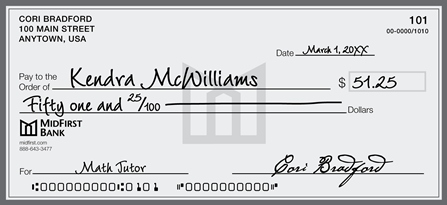

In [101]:
img_fp : str = os.path.join(
    os.path.split(os.path.abspath(''))[0], 
    'demo_data/check-example-generic.jpg'
)
with open(img_fp, 'rb') as f: 
    img_data : bytes = f.read()

display(Image.open(io.BytesIO(img_data)))

### Initialize an AWS Textract Client

In [102]:
session = boto3.Session(profile_name='textract')
client = session.client('textract', region_name='us-east-1')

### Execute OCR 
Using AWS Textract

In [103]:
resp : dict = client.detect_document_text(Document={'Bytes': img_data})

### Counters
Count the distribution of block types in the response.

In [104]:
block_type_distribution = Counter()
for block in resp['Blocks']:
    block_type_distribution[block['BlockType']] += 1
print(block_type_distribution)

Counter({'WORD': 38, 'LINE': 20, 'PAGE': 1})


20


### Sample Block (Line) Output

In [107]:
lines = [block for block in resp['Blocks'] if block['BlockType'] == 'LINE']
print(json.dumps(lines[2], indent=2))

{
  "BlockType": "LINE",
  "Confidence": 99.97354125976562,
  "Text": "100 MAIN STREET",
  "Geometry": {
    "BoundingBox": {
      "Width": 0.17053361237049103,
      "Height": 0.03674341365695,
      "Left": 0.04196561500430107,
      "Top": 0.12040838599205017
    },
    "Polygon": [
      {
        "X": 0.04196561500430107,
        "Y": 0.12040838599205017
      },
      {
        "X": 0.2124493420124054,
        "Y": 0.12090837955474854
      },
      {
        "X": 0.2124992161989212,
        "Y": 0.15715180337429047
      },
      {
        "X": 0.04198896139860153,
        "Y": 0.15666906535625458
      }
    ]
  },
  "Id": "223e9cc9-be94-413e-9ca0-b3b6eca6965f",
  "Relationships": [
    {
      "Type": "CHILD",
      "Ids": [
        "614ca6cc-1a1e-4da3-91f0-6b0f962c8b30",
        "c64ffb89-cf16-4781-ac25-f853811bc1e4",
        "5989f61f-5ff5-4f01-a745-ee0fe5a013af"
      ]
    }
  ]
}


### Pandas DataFrame
Place the line data from AWS Textract into a Pandas DataFrame

In [108]:
rows : List[dict] = []

for block in resp['Blocks']:
    row : dict = {}
    for k, v in block.items():
        # Check if the type is NOT a list or dictionary.
        if not hasattr(v, 'keys') and not hasattr(v, 'append'):
            row[k] = v

    box = block['Geometry']['BoundingBox']
    row['xmin'] = box['Left']
    row['ymin'] = box['Top']
    row['xmax'] = box['Left'] + box['Width']
    row['ymax'] = box['Top'] + box['Height']

    poly = block['Geometry']['Polygon']
    row['xPoly0'], row['yPoly0'] = poly[0]['X'], poly[0]['Y']
    row['xPoly1'], row['yPoly1'] = poly[1]['X'], poly[1]['Y']
    row['xPoly2'], row['yPoly2'] = poly[2]['X'], poly[2]['Y']
    row['xPoly3'], row['yPoly3'] = poly[3]['X'], poly[3]['Y']

    vertices : Tuple[float, float] = [
        (poly[0]['X'], poly[0]['Y']), (poly[1]['X'], poly[1]['Y']), 
        (poly[2]['X'], poly[2]['Y']), (poly[3]['X'], poly[3]['Y'])
    ]
    polygon = Polygon(vertices)
    centroid = list(polygon.centroid.coords)[0]
    row['centerX'], row['centerY'] = centroid[0], centroid[1]
    rows.append(row)

df = pd.DataFrame(rows)

Record relationshps in a seperate dataframe.

In [109]:
rows = []
for block in resp['Blocks']:
    if 'Relationships' not in block:
        continue
    for rel in block['Relationships']:
        # The examples I have worked with only deal with CHILD
        # type relationships. Skip relation that isn't of type
        # "CHILD" 
        if rel['Type'] != 'CHILD':
            continue
        for child_id in rel['Ids']:
            rows.append({'ParentId': block['Id'], 'Id': child_id})
rel_df = pd.DataFrame(rows)

In [110]:
df = df.merge(rel_df, on='Id', how='left')

In [111]:
df

,BlockType,Id,xmin,ymin,xmax,ymax,xPoly0,yPoly0,xPoly1,yPoly1,xPoly2,yPoly2,xPoly3,yPoly3,centerX,centerY,Confidence,Text,TextType,ParentId
0,PAGE,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c,0.004137,0.008790,1.000000,1.000000,0.004137,0.008790,0.998655,0.012017,1.000000,1.000000,0.004616,1.000000,0.501582,0.505273,NaN,NaN,NaN,NaN
1,LINE,74d23956-4b0d-4486-bb83-20eb9b3e0f85,0.041295,0.071792,0.205958,0.108386,0.041295,0.071792,0.205909,0.072297,0.205958,0.108386,0.041319,0.107898,0.123614,0.090094,97.098473,CORI BRADFORD,NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
2,LINE,7deee7d8-68b2-4cfe-91d5-6acb0f559edd,0.914970,0.074480,0.955044,0.119020,0.914970,0.074480,0.954841,0.074602,0.955044,0.119020,0.915165,0.118902,0.935004,0.096752,99.977280,101,NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
3,LINE,223e9cc9-be94-413e-9ca0-b3b6eca6965f,0.041966,0.120408,0.212499,0.157152,0.041966,0.120408,0.212449,0.120908,0.212499,0.157152,0.041989,0.156669,0.127219,0.138785,99.973541,100 MAIN STREET,NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
4,LINE,2ef68c78-b3c2-4d09-8698-0ac291d6fec1,0.862888,0.134058,0.959286,0.166243,0.862888,0.134058,0.959140,0.134337,0.959286,0.166243,0.863022,0.165973,0.911082,0.150153,99.153236,00-0000/1010,NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
5,LINE,bfecde6d-26d9-47cd-9360-33f9ca7952fc,0.040541,0.168679,0.193226,0.210222,0.040541,0.168679,0.193173,0.169106,0.193226,0.210222,0.040567,0.209812,0.116871,0.189455,91.830009,"ANYTOWN, USA",NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
6,LINE,021e3889-7625-4e90-81cb-5bd43c99236c,0.616943,0.216456,0.825127,0.277362,0.616943,0.216456,0.824885,0.217010,0.825127,0.277362,0.617131,0.276842,0.721011,0.246919,92.091080,"Date March 1, 20XX",NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
7,LINE,ffc5a411-170c-4220-9244-2c7e5bc9c904,0.041603,0.352908,0.127784,0.399008,0.041603,0.352908,0.127738,0.353105,0.127784,0.399008,0.041633,0.398823,0.084688,0.375962,99.952126,Pay to the,NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
8,LINE,80379cb6-d4f2-46e9-84cf-1d6b4455bae3,0.155710,0.320351,0.577444,0.437375,0.155710,0.320351,0.577103,0.321351,0.577444,0.437375,0.155842,0.436511,0.366483,0.378902,98.529449,Kendra McWilliams,NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
9,LINE,810c7299-d476-4586-bdf3-dfa8ed1b6484,0.041322,0.402910,0.112142,0.442608,0.041322,0.402910,0.112105,0.403062,0.112142,0.442608,0.041348,0.442465,0.076728,0.422762,99.764793,Order of,NaN,7a2a5b39-4dc1-4a04-a692-d7ff82b2146c
